In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import r2_score

import itertools
import datetime
import copy
import sys  
import glob

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.deep_learning import tf_metrics as metrics
from soundings.preprocessing import dataloader as dl
from soundings.plotting import radiosonde_plotting, results
from soundings.utils import radiosonde_utils

VOL = '/mnt/data1/stock/mlsoundings'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [3]:
gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    # tf.config.experimental.set_visible_devices(device, 'GPU')
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Thu May  6 23:23:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   32C    P8    12W / 260W |     16MiB / 24212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000

In [4]:
def plot_results(Y, T, file_name=None):
    
    default_font = 14
    figure_width = 6
    figure_height = 4
    line_width = 2.5
    
    titles = ['CAPE', 'CIN']
    for i in range(2):
        
        fig, ax = plt.subplots(1, 1, figsize=(figure_width, figure_height))
        ax.plot(Y[:,i], T[:,i], '.', color='gray')
        mi = min(min(Y[:,i]), min(T[:,i]))
        ma = max(max(Y[:,i]), max(T[:,i]))
        
        ax.plot(np.arange(mi, ma), np.arange(mi, ma), color='blue', linewidth=line_width)
        
        ax.set_title(titles[i], fontsize=default_font, loc='left', weight='bold')
        
        ax.set_title(f'$R^2$: {r2_score(Y[:,i], T[:,i]):.3f}, RMSE: {ml.rmse(Y[:,i], T[:,i]):.3f} J/kg',
                     loc='right', fontsize=12, fontstyle='italic')
        ax.set_xlabel('Predicted Value', fontsize=default_font)
        ax.set_ylabel('Target Value', fontsize=default_font)
        ax.tick_params(axis='x', labelsize=default_font)
        ax.tick_params(axis='y', labelsize=default_font)
        
        ax.grid(True)
        fig.tight_layout()
        
        if file_name:
            _file_name = f'/home/stock/research/media/{file_name}{titles[i]}.pdf'
            plt.savefig(_file_name, dpi=300, bbox_inches='tight')
            
            
def cape_cin_metrics(Y, T, zeros=None):
    lables = ['CAPE', 'CIN']
    for i in range(2):
        print(f'{lables[i]} R^2: {r2_score(Y[:,i], T[:,i]):.3f}, RMSE: {ml.rmse(Y[:,i], T[:,i]):.3f} J/kg', end='')
        if zeros is not None:
            print(f' | zeros R^2: {r2_score(Y[zeros[i],i], T[zeros[i],i]):.3f}, RMSE: {ml.rmse(Y[zeros[i],i], T[zeros[i],i]):.3f} J/kg')
        else: print()

In [15]:
container = np.load(os.path.join(VOL, 'preprocessed_alley.npz'))

raob = container['raob']
rap  = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files']

container.close()

print(raob.shape, rap.shape, goes.shape, rtma.shape)

(38373, 256, 4) (38373, 256, 4) (38373, 3, 3, 8) (38373, 3, 3, 3)


## RAOB Product

In [27]:
raob_cape_cin = np.load(os.path.join(VOL, 'alley_raob_cape_cin.npy'))
rap_cape_cin = np.load(os.path.join(VOL, 'alley_rap_cape_cin.npy'))
ml_test_cape_cin = np.load(os.path.join(VOL, 'alley_ml_cape_cin.npy'))

# nans = np.unique(np.concatenate([np.unique(np.argwhere(np.isnan(raob_cape_cin))[:, 0]), # nans
#                                  np.unique(np.argwhere(np.isnan(rap_cape_cin))[:, 0]),
#                                  np.unique(np.argwhere(raob_cape_cin[:,0] < 0)), # cape < 0
#                                  np.unique(np.argwhere(rap_cape_cin[:,0] < 0)),
#                                  np.unique(np.argwhere(raob_cape_cin[:,0] > 7000)), # cape>7000
#                                  np.unique(np.argwhere(rap_cape_cin[:,0] > 7000)),
#                                  np.unique(np.argwhere(raob_cape_cin[:,1] < -1000)), # cin<1000
#                                  np.unique(np.argwhere(rap_cape_cin[:,1] < -1000))
#                                 ]))

# raob_cape_cin = np.delete(raob_cape_cin, nans, axis=0)
# rap_cape_cin = np.delete(rap_cape_cin, nans, axis=0)

# raob = np.delete(raob, nans, axis=0)
# rap  = np.delete(rap, nans, axis=0)
# goes = np.delete(goes, nans, axis=0)
# rtma = np.delete(rtma, nans, axis=0)
# sonde_files = np.delete(sonde_files, nans, axis=0)

print(raob_cape_cin.shape, rap_cape_cin.shape, raob.shape, rap.shape, goes.shape, rtma.shape)

(37490, 2) (37490, 2) (37490, 256, 4) (37490, 256, 4) (37490, 3, 3, 8) (37490, 3, 3, 3)


In [7]:
train_i, val_i, test_i = ml.standard_partition_indicies(sonde_files, percentages=(0.75,0.10,0.15),
                                                        shuffle=True, seed=1234)

RAPtrain,  RAPval,  RAPtest  = rap[train_i], rap[val_i], rap[test_i]
RTMAtrain, RTMAval, RTMAtest = rtma[train_i], rtma[val_i], rtma[test_i]
GOEStrain, GOESval, GOEStest = goes[train_i], goes[val_i], goes[test_i]
RAOBtrain, RAOBval, RAOBtest = raob[train_i], raob[val_i], raob[test_i]
FILEtrain, FILEval, FILEtest = sonde_files[train_i], sonde_files[val_i], sonde_files[test_i]

RAPCCtrain , RAPCCval , RAPCCtest  = rap_cape_cin[train_i] , rap_cape_cin[val_i] , rap_cape_cin[test_i]
RAOBCCtrain, RAOBCCval, RAOBCCtest = raob_cape_cin[train_i], raob_cape_cin[val_i], raob_cape_cin[test_i]

# diff_cape_cin = raob_cape_cin - rap_cape_cin
# DIFFCCtrain, DIFFCCval, DIFFCCtest = diff_cape_cin[train_i], diff_cape_cin[val_i], diff_cape_cin[test_i]

input_dims = [dl.PRESSURE, dl.TEMPERATURE, dl.DEWPOINT] #, dl.ALTITUDE]

Xtrain, Ttrain = RAPtrain[:,:,input_dims], RAOBCCtrain
Xval  , Tval   = RAPval[:,:,input_dims]  , RAOBCCval
Xtest , Ttest  = RAPtest[:,:,input_dims] , RAOBCCtest

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((28113, 256, 3),
 (28113, 2),
 (3747, 256, 3),
 (3747, 2),
 (5598, 256, 3),
 (5598, 2))

In [77]:
def filter_invalid(RAPCC, RAOBCC):
    nans = np.unique(np.concatenate([np.unique(np.argwhere(np.isnan(RAOBCC))[:, 0]), # nans
                                     np.unique(np.argwhere(np.isnan(RAPCC))[:, 0]),
                                     np.unique(np.argwhere(RAOBCC[:,0] < 0)), # cape < 0
                                     np.unique(np.argwhere(RAPCC[:,0] < 0)),
                                     np.unique(np.argwhere(RAOBCC[:,0] > 7000)), # cape>7000
                                     np.unique(np.argwhere(RAPCC[:,0] > 7000)),
                                     np.unique(np.argwhere(RAOBCC[:,1] < -1000)), # cin<1000
                                     np.unique(np.argwhere(RAPCC[:,1] < -1000)),
                                    ]))
    return nans

In [78]:
nans = filter_invalid(RAPCCtrain, RAOBCCtrain)
Xtrain = np.delete(Xtrain, nans, axis=0)
Ttrain = np.delete(Ttrain, nans, axis=0)
RAPCCtrain = np.delete(RAPCCtrain, nans, axis=0)
RAOBCCtrain = np.delete(RAOBCCtrain, nans, axis=0)

nans = filter_invalid(RAPCCval, RAOBCCval)
Xval = np.delete(Xval, nans, axis=0)
Tval = np.delete(Tval, nans, axis=0)
RAPCCval = np.delete(RAPCCval, nans, axis=0)
RAOBCCval = np.delete(RAOBCCval, nans, axis=0)

nans = filter_invalid(RAPCCtest, RAOBCCtest)
Xtest = np.delete(Xtest, nans, axis=0)
Ttest = np.delete(Ttest, nans, axis=0)
RAPCCtest = np.delete(RAPCCtest, nans, axis=0)
RAOBCCtest = np.delete(RAOBCCtest, nans, axis=0)

ml_test_cape_cin = np.delete(ml_test_cape_cin, nans, axis=0)

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((28109, 256, 3),
 (28109, 2),
 (3763, 256, 3),
 (3763, 2),
 (5600, 256, 3),
 (5600, 2))

## Profiling Products

In [173]:
cape_zeros = np.argwhere((RAPCCtest[:,0] != 0) & (RAOBCCtest[:,0] != 0))
cin_zeros  = np.argwhere((RAPCCtest[:,1] != 0) & (RAOBCCtest[:,1] != 0))
cape_zeros.shape, cin_zeros.shape
print('RAP')
cape_cin_metrics(RAPCCtest, RAOBCCtest, [cape_zeros, cin_zeros])
print('Profiles')
cape_cin_metrics(ml_test_cape_cin, RAOBCCtest, [cape_zeros, cin_zeros])

RAP
CAPE R^2: 0.876, RMSE: 282.068 J/kg | zeros R^2: 0.834, RMSE: 437.772 J/kg
CIN R^2: 0.531, RMSE: 82.805 J/kg | zeros R^2: 0.784, RMSE: 92.009 J/kg
Profiles
CAPE R^2: 0.874, RMSE: 265.297 J/kg | zeros R^2: 0.835, RMSE: 411.316 J/kg
CIN R^2: 0.409, RMSE: 85.672 J/kg | zeros R^2: 0.630, RMSE: 111.898 J/kg


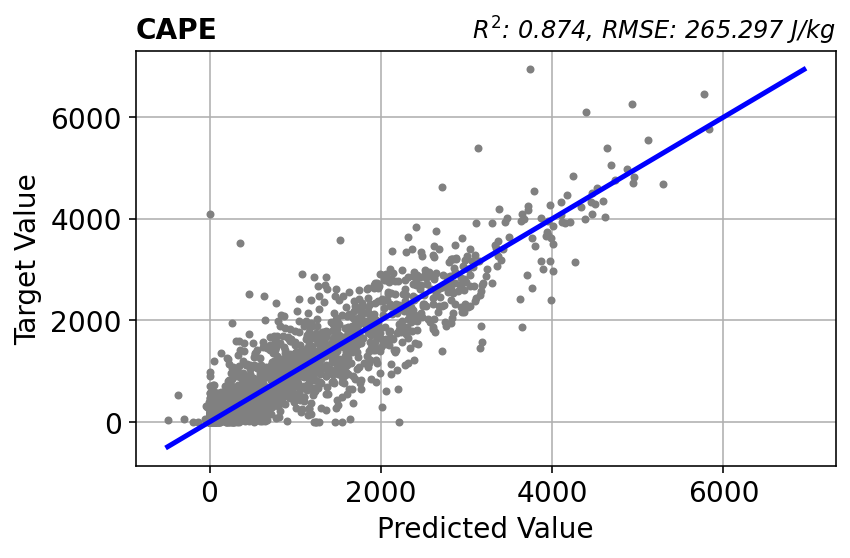

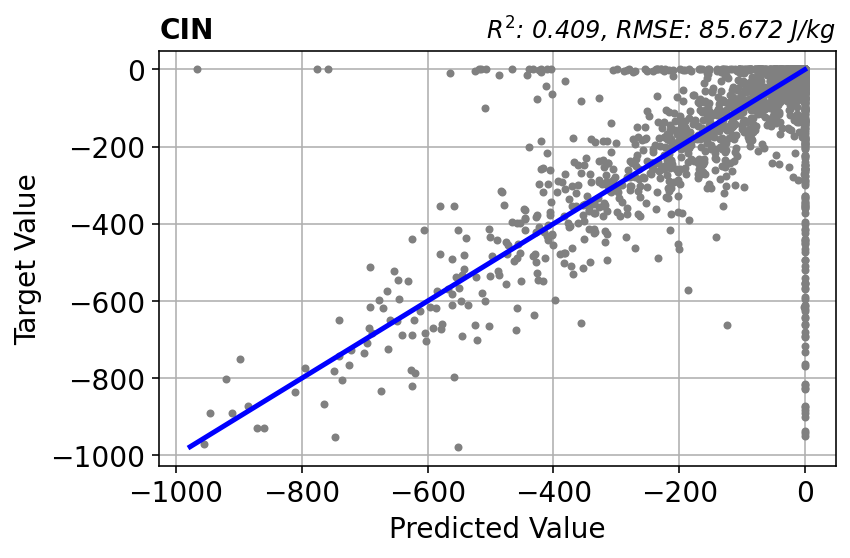

In [80]:
plot_results(ml_test_cape_cin, Ttest) #. , file_name='cnn_sounding_products_')

In [28]:
np.argmin(raob_cape_cin[:,1]), np.argmax(raob_cape_cin[:,0])

(17865, 20016)

In [36]:
[s for s in sonde_files if ('unr' in s and '2019-09-04T23:06' in s)]

['unr_2019-09-04T23:06:00.000000000_noaa-esrl-2019090500-raob_-103.21_44.07']

In [37]:
np.argwhere(sonde_files == 'unr_2019-09-04T23:06:00.000000000_noaa-esrl-2019090500-raob_-103.21_44.07')

array([[37059]])

[2149.86724485 -140.82960745]


(<Figure size 576x576 with 1 Axes>,
 <metpy.plots.skewt.SkewT at 0x7f51e4cd1400>)

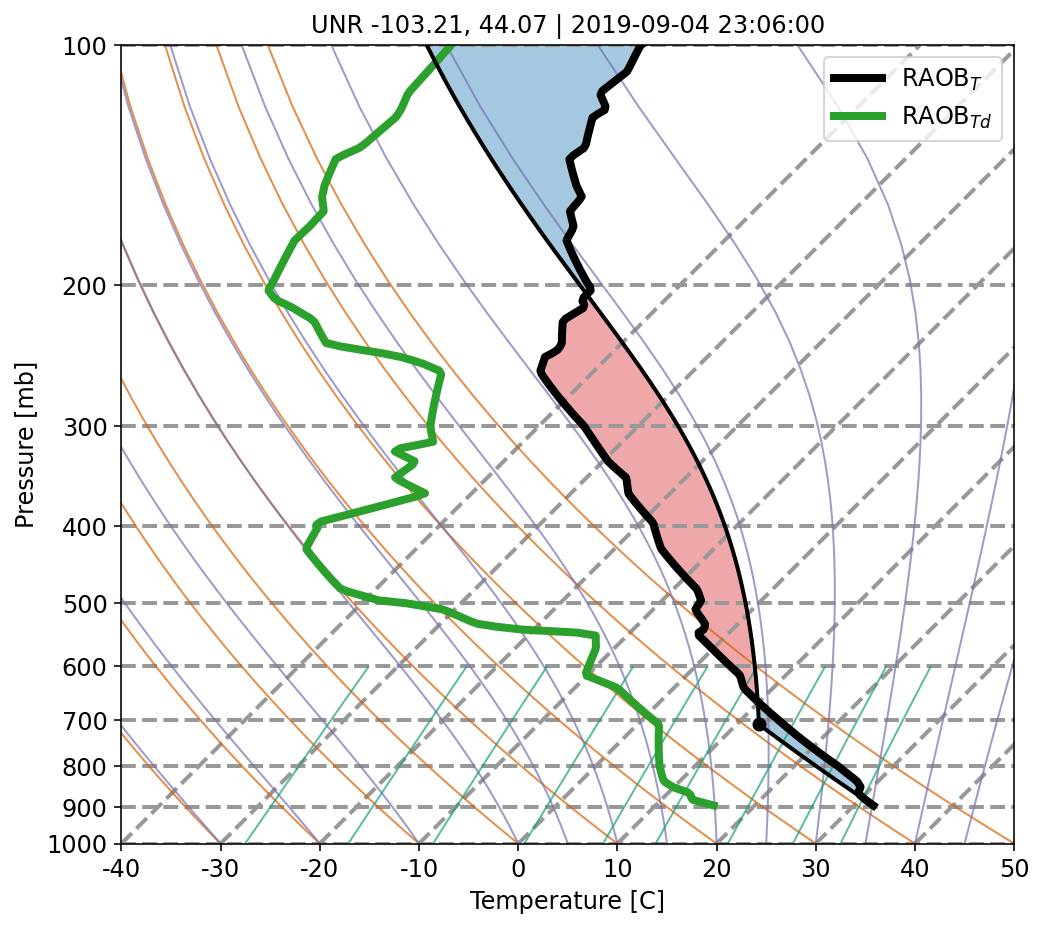

In [39]:
index = 37059 # 1009 # 1716 # 5002 # 970 # 1126
print(raob_cape_cin[index,:])
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = raob[index,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = raob[index,:,dl.TEMPERATURE]
sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = raob[index,:,dl.DEWPOINT]

content = sonde_files[index].split('_')
date = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f')
lon, lat = content[-2], content[-1]
title = f'{content[0].upper()} {lon}, {lat} | {date}'
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title, cape_cin=True)#,
#                                          file_name=f"/home/stock/research/media/cape_cin_{content[0]}-{content[1]}_unet_upperair.pdf");

In [81]:
# RAOB Stats
raob_cape_cin = np.concatenate([RAOBCCtrain, RAOBCCval, RAOBCCtest])
print('sem:',stats.sem(raob_cape_cin, axis=0))
print('median:',np.median(raob_cape_cin, axis=0))
df = pd.DataFrame(raob_cape_cin)
df.describe()

sem: [4.03261654 0.67355321]
median: [0. 0.]


,0,1
count,37472.000000,37472.000000
mean,331.574183,-47.431291
std,780.621240,130.384315
min,0.000000,-999.684374
25%,0.000000,-1.560073
50%,0.000000,0.000000
75%,117.132880,0.000000
max,6940.407247,0.000000


In [82]:
# RAP Stats
rap_cape_cin = np.concatenate([RAPCCtrain, RAPCCval, RAPCCtest])
print('sem:',stats.sem(rap_cape_cin, axis=0))
print('median:',np.median(rap_cape_cin, axis=0))
df = pd.DataFrame(rap_cape_cin)
df.describe()

sem: [4.16639099 0.62947551]
median: [0. 0.]


,0,1
count,37472.000000,37472.000000
mean,344.761665,-43.073130
std,806.516878,121.851892
min,0.000000,-988.906088
25%,0.000000,-1.224414
50%,0.000000,0.000000
75%,136.158135,0.000000
max,6781.620408,0.000000


Text(0.5, 1.0, 'Boxplot of CAPE/CIN values')

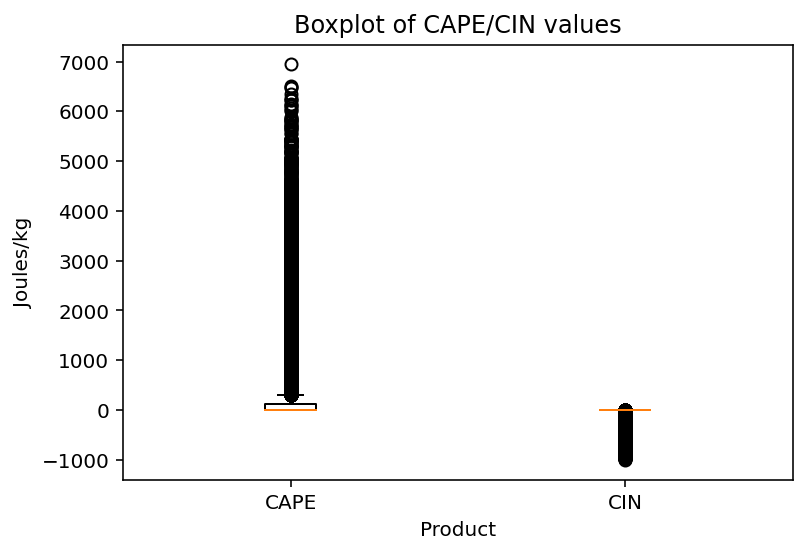

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax.boxplot(raob_cape_cin)
ax.set_xticklabels(['CAPE', 'CIN'])
ax.set_ylabel('Joules/kg'); ax.set_xlabel('Product')
ax.set_title('Boxplot of CAPE/CIN values')
# plt.savefig('/home/stock/research/media/cape_cin_boxplot.pdf', dpi=300, bbox_inches='tight')

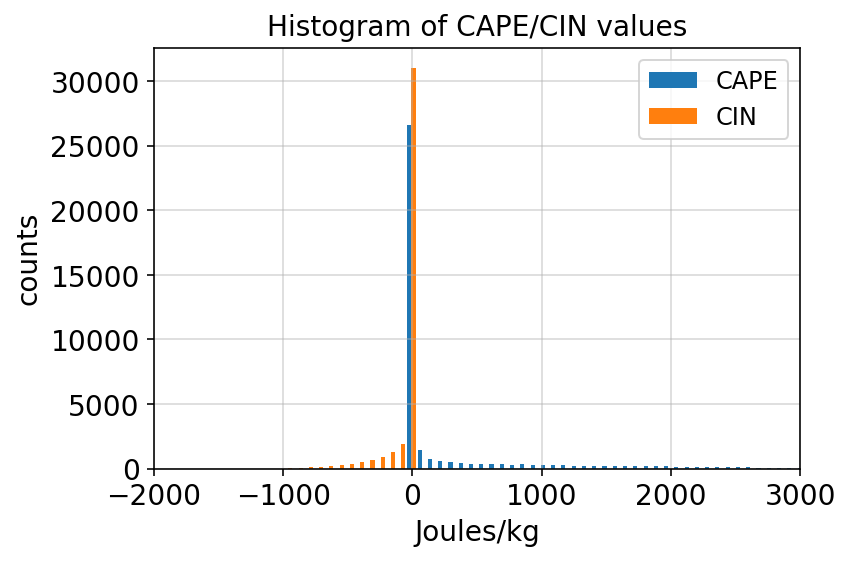

In [84]:
default_font = 14
figure_width = 6
figure_height = 4
line_width = 2.5

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax.hist(raob_cape_cin, bins=100, label=['CAPE', 'CIN']);
ax.legend(fontsize=12)
ax.set_ylabel('counts', fontsize=default_font)
ax.set_xlabel('Joules/kg', fontsize=default_font)
ax.set_title('Histogram of CAPE/CIN values', fontsize=default_font)
ax.set_xlim((-2000, 3000))
ax.grid(True, alpha=0.5)

ax.tick_params(axis='x', labelsize=default_font)
ax.tick_params(axis='y', labelsize=default_font)
        
fig.tight_layout()
        
# plt.savefig('/home/stock/research/media/cape_cin_histogram.pdf', dpi=300, bbox_inches='tight')

In [209]:
conv_layers = [32, 32, 32, 64, 64, 64] # [32, 64, 128, 256, 512]
nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], conv_layers, 
                                     [(3,1)]*len(conv_layers), Ttrain.shape[1], 
                                     n_hiddens_list=[128], activation='relu', 
                                     dense_activation='relu', dropout=False, 
                                     batchnorm=False, seed=1234)
nnet.train(Xtrain, Ttrain, 100, 64, method='adam', learning_rate=0.0001, loss_f='Huber', 
           verbose=True, validation=(Xval, Tval))
nnet.model.summary()

epoch: 0, rmse 0.86959, val_rmse 0.79096
epoch: 20, rmse 0.47977, val_rmse 0.49141
epoch: 40, rmse 0.44719, val_rmse 0.46729
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 3)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 256, 32)           320       
_________________________________________________________________
activation (Activation)      (None, 256, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           3104      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 32)           0     

In [210]:
nnet

ConvolutionalNeuralNetwork((256, 3), [32, 32, 32, 64, 64, 64], [(3, 1), (3, 1), (3, 1), (3, 1), (3, 1), (3, 1)], 2)
  Final objective value is 0.07120 in 77.2827 seconds.

In [211]:
print('Epochs=', len(nnet.history['loss']))

Epochs= 45


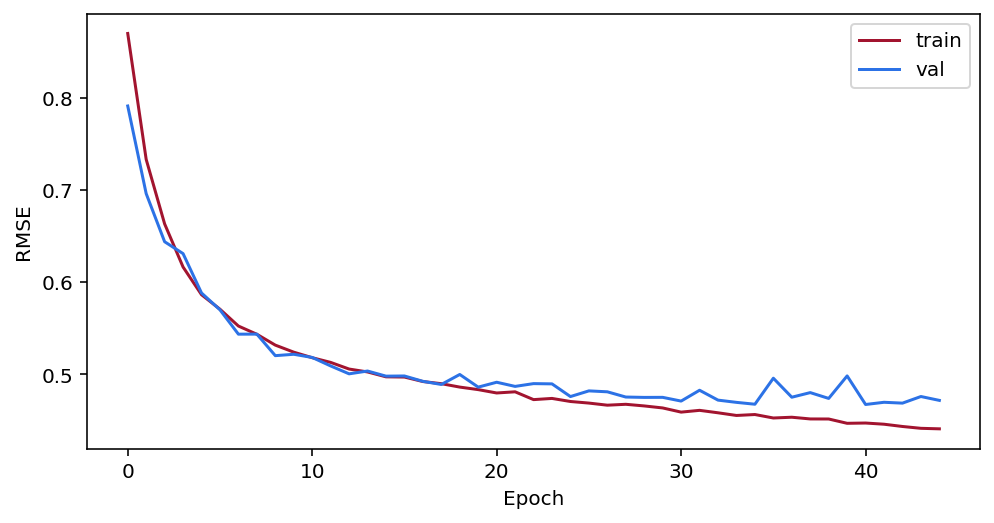

In [212]:
results.plot_loss(nnet)

In [213]:
# [32, 32, 32, 64, 64, 64] [128] (3,1)
Y = nnet.use(Xtest)

print('RAP')
cape_cin_metrics(RAPCCtest, RAOBCCtest, [cape_zeros, cin_zeros])
print('ML')
cape_cin_metrics(Y, RAOBCCtest, [cape_zeros, cin_zeros])

RAP
CAPE R^2: 0.876, RMSE: 282.068 J/kg | zeros R^2: 0.834, RMSE: 437.772 J/kg
CIN R^2: 0.531, RMSE: 82.805 J/kg | zeros R^2: 0.784, RMSE: 92.009 J/kg
ML
CAPE R^2: 0.874, RMSE: 274.511 J/kg | zeros R^2: 0.826, RMSE: 422.073 J/kg
CIN R^2: 0.452, RMSE: 74.806 J/kg | zeros R^2: 0.586, RMSE: 103.812 J/kg


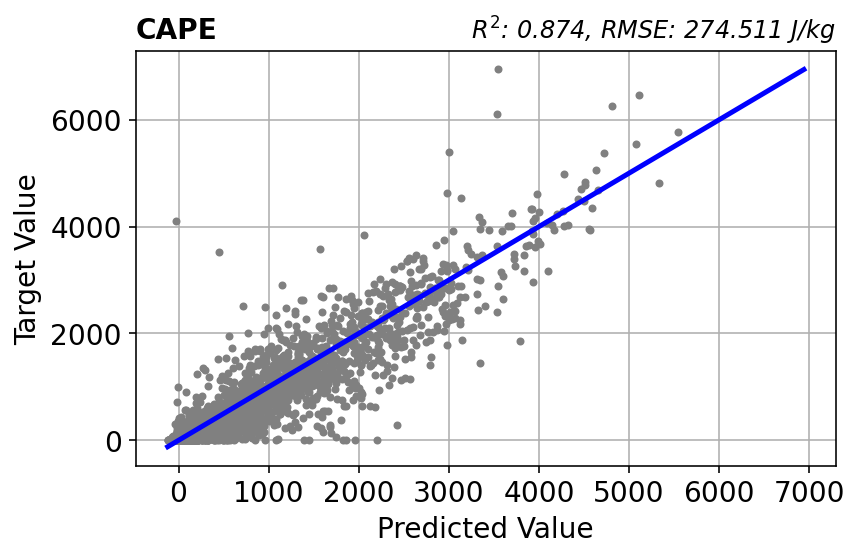

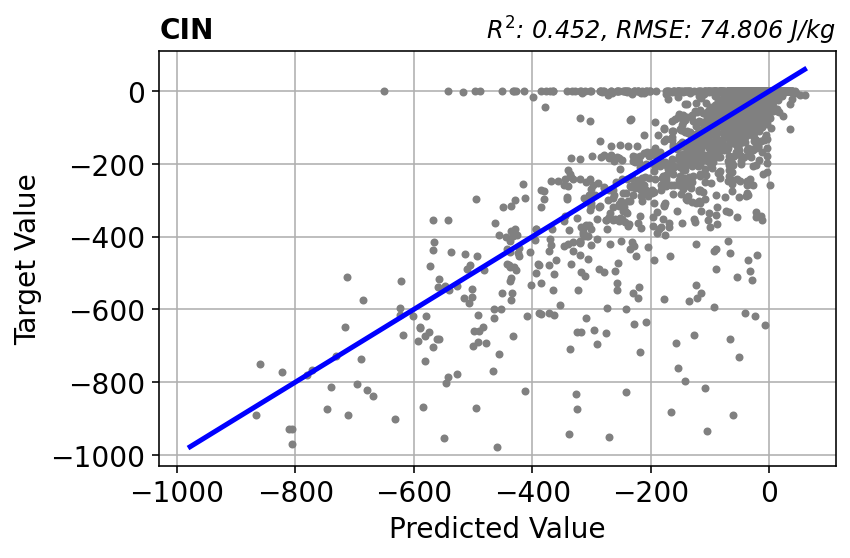

In [215]:
# Huber FC
plot_results(Y, Ttest, file_name='cnn_sounding_products_')

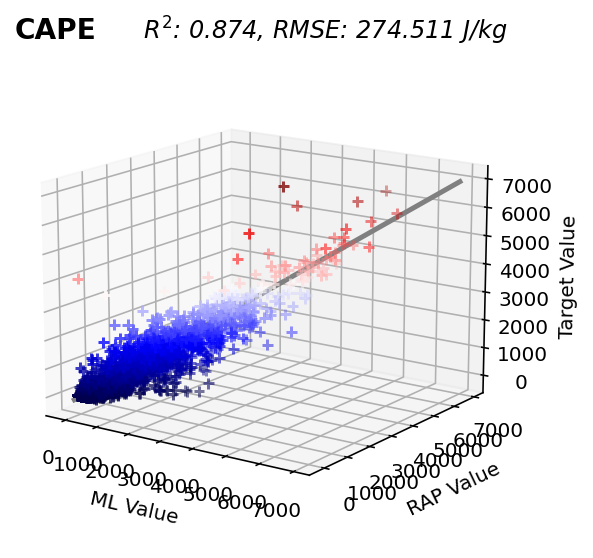

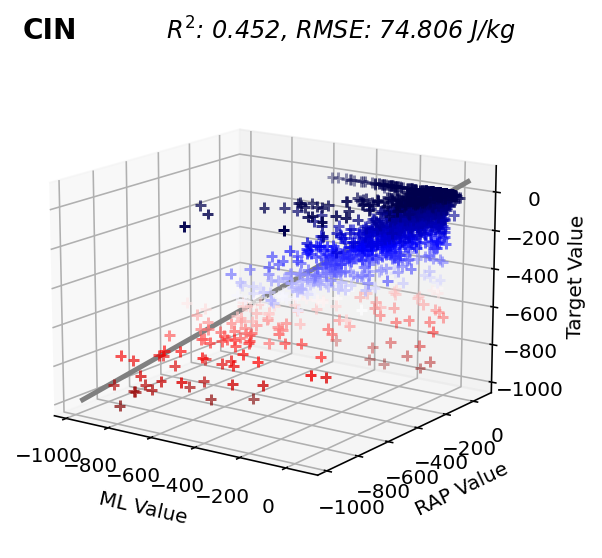

In [216]:
def plot_results_3(Y, T, R, file_name=None):
    
    default_font = 14
    figure_width = 6
    figure_height = 4
    line_width = 2.5

    titles = ['CAPE', 'CIN']
    for i in range(2):

        fig = plt.figure(figsize=(figure_width, figure_height))
        ax = fig.add_subplot(111, projection='3d')
        c = np.abs(T[:,i])
        ax.scatter(Y[:,i], R[:,i], T[:,i], marker='+', c=c, s=30, cmap=cm.seismic)
        mi = min(min(Y[:,i]), min(R[:,i]), min(T[:,i]))
        ma = max(max(Y[:,i]), max(R[:,i]), max(T[:,i]))

        ax.plot(np.arange(mi, ma), np.arange(mi, ma), np.arange(mi, ma),
                color='gray', linewidth=line_width)

        ax.set_title(titles[i], fontsize=default_font, loc='left', weight='bold')

        ax.set_title(f'$R^2$: {r2_score(Y[:,i], T[:,i]):.3f}, RMSE: {ml.rmse(Y[:,i], T[:,i]):.3f} J/kg',
                     loc='right', fontsize=12, fontstyle='italic')
        ax.set_xlabel('ML Value')
        ax.set_ylabel('RAP Value')
        ax.set_zlabel('Target Value')
#         ax.tick_params(axis='x', labelsize=10)
#         ax.tick_params(axis='y', labelsize=10)
#         ax.tick_params(axis='z', labelsize=10)
#         ax.xaxis.pane.fill = False
#         ax.yaxis.pane.fill = False
#         ax.zaxis.pane.fill = False
        ax.view_init(15, -55)
        ax.grid(True)
        fig.tight_layout()
        
        if file_name:
            _file_name = f'/home/stock/research/media/{file_name}{titles[i]}.pdf'
            plt.savefig(_file_name, dpi=300, bbox_inches='tight')
        
plot_results_3(Y, Ttest, RAPCCtest, file_name='cnn_sounding_products_3d_')

In [217]:
def plot_results_2(Y, T, R, file_name=None):
    
    default_font = 14
    figure_width = 6
    figure_height = 4
    line_width = 2.5
    
    titles = ['CAPE', 'CIN']
    for i in range(2):
        
        fig, ax = plt.subplots(1, 1, figsize=(figure_width, figure_height))
        ax.plot(R[:,i], T[:,i], '+', color='green', label='RAP')
        ax.plot(Y[:,i], T[:,i], 'x', color='gray', label='ML')
        mi = min(min(Y[:,i]), min(T[:,i]))
        ma = max(max(Y[:,i]), max(T[:,i]))
        
        ax.plot(np.arange(mi, ma), np.arange(mi, ma), color='blue', linewidth=line_width)
        
        ax.set_title(titles[i], fontsize=default_font, loc='left', weight='bold')
        
        ax.set_title(f'$R^2$: {r2_score(Y[:,i], T[:,i]):.3f}, RMSE: {ml.rmse(Y[:,i], T[:,i]):.3f} J/kg',
                     loc='right', fontsize=12, fontstyle='italic')
        ax.set_xlabel('Estimated Value', fontsize=default_font)
        ax.set_ylabel('Target Value', fontsize=default_font)
        ax.tick_params(axis='x', labelsize=default_font)
        ax.tick_params(axis='y', labelsize=default_font)
        ax.legend()
        
        ax.grid(True)
        fig.tight_layout()
        
        if file_name:
            _file_name = f'/home/stock/research/media/{file_name}{titles[i]}.pdf'
            plt.savefig(_file_name, dpi=300)

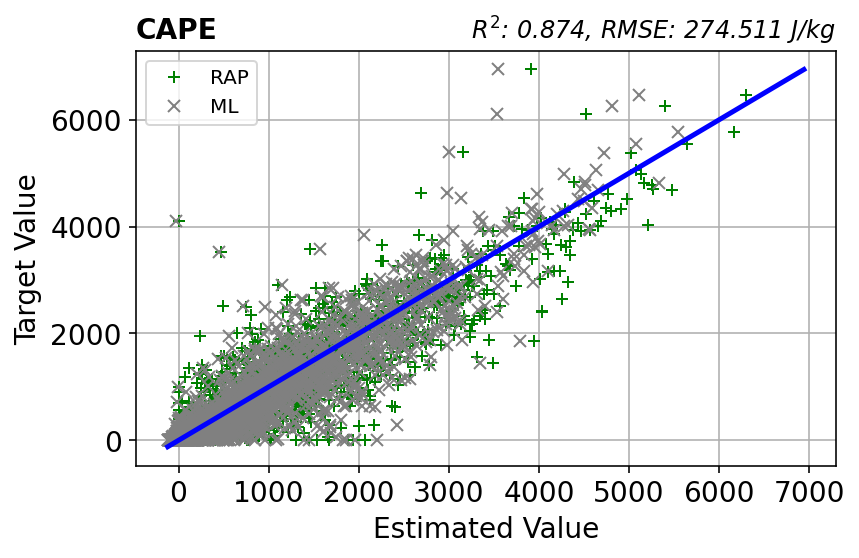

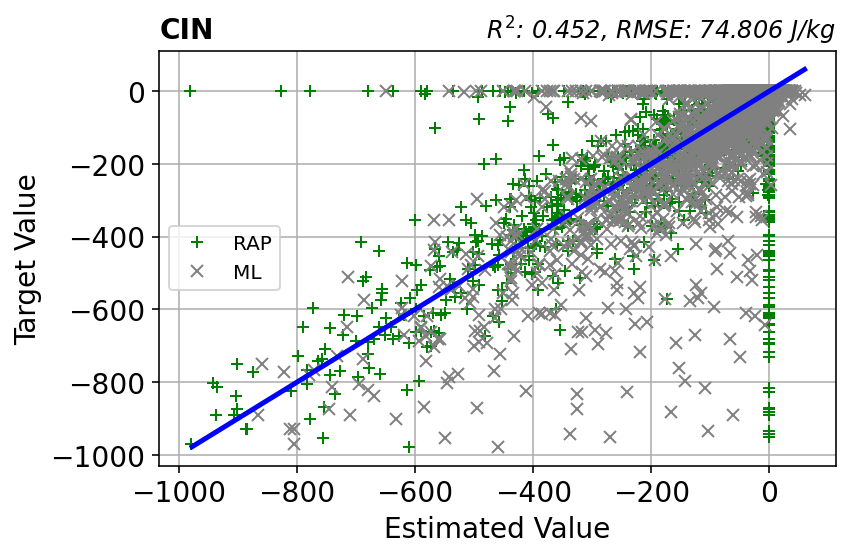

In [218]:
plot_results_2(Y, Ttest, RAPCCtest, file_name='cnn_sounding_products_rap_')

In [101]:
# RAOB Stats
print('sem:',stats.sem(RAOBCCtest, axis=0))
print('median:',np.median(RAOBCCtest, axis=0))
df = pd.DataFrame(RAOBCCtest)
df.describe()

sem: [10.52709586  1.68928278]
median: [0. 0.]


,0,1
count,5598.000000,5598.000000
mean,336.549793,-46.378185
std,787.635033,126.391772
min,0.000000,-977.409128
25%,0.000000,-2.070534
50%,0.000000,0.000000
75%,121.020425,0.000000
max,6152.592541,0.000000


In [102]:
# RAP Stats
print('sem:',stats.sem(RAPCCtest, axis=0))
print('median:',np.median(RAPCCtest, axis=0))
df = pd.DataFrame(RAPCCtest)
df.describe()

sem: [10.8881017   1.58700608]
median: [0. 0.]


,0,1
count,5598.000000,5598.000000
mean,346.455777,-42.625659
std,814.645412,118.739451
min,0.000000,-900.943075
25%,0.000000,-1.479371
50%,0.000000,0.000000
75%,137.641440,0.000000
max,5910.995169,0.000000


In [103]:
# ML Stats
print('sem:',stats.sem(Y, axis=0))
print('median:',np.median(Y, axis=0))
df = pd.DataFrame(Y)
df.describe()

sem: [10.22241423  1.4875334 ]
median: [34.96451609 -2.02803748]


,0,1
count,5598.000000,5598.000000
mean,362.504960,-46.310106
std,764.838819,111.296927
min,-94.051699,-906.794578
25%,13.510265,-34.099674
50%,34.964516,-2.028037
75%,196.683407,2.983486
max,5379.974087,52.897257


## Residual Products

In [74]:
raob_cape_cin = np.load(os.path.join(VOL, 'alley_raob_cape_cin.npy'))
rap_cape_cin = np.load(os.path.join(VOL, 'alley_rap_cape_cin.npy'))

nans = np.unique(np.concatenate([np.unique(np.argwhere(np.isnan(raob_cape_cin))[:, 0]),
                                 np.unique(np.argwhere(np.isnan(rap_cape_cin))[:, 0]),
                                 np.unique(np.argwhere(raob_cape_cin[:,0] < 0)),
                                 np.unique(np.argwhere(rap_cape_cin[:,0] < 0))]))

raob_cape_cin = np.delete(raob_cape_cin, nans, axis=0)
rap_cape_cin = np.delete(rap_cape_cin, nans, axis=0)

raob = np.delete(raob, nans, axis=0)
rap  = np.delete(rap, nans, axis=0)
goes = np.delete(goes, nans, axis=0)
rtma = np.delete(rtma, nans, axis=0)
sonde_files = np.delete(sonde_files, nans, axis=0)

print(raob_cape_cin.shape, rap_cape_cin.shape, raob.shape, rap.shape, goes.shape, rtma.shape)

((38373, 2), (38373, 2), (758,))

In [87]:
# pull example from thesis to get rap and raob cape/cin
thesis_eg_i = np.argmin(abs(raob_cape_cin - [2149.867, -140.830]), axis=0)[0]
raob_cape_cin[thesis_eg_i], rap_cape_cin[thesis_eg_i]

(array([2149.86724485, -140.82960745]), array([1942.10500115,  -50.00094256]))

In [88]:
diff_cape_cin = raob_cape_cin - rap_cape_cin

In [89]:
train_i, val_i, test_i = ml.standard_partition_indicies(sonde_files, percentages=(0.75,0.10,0.15),
                                                        shuffle=True, seed=1234)

RAPtrain,  RAPval,  RAPtest  = rap[train_i], rap[val_i], rap[test_i]
RTMAtrain, RTMAval, RTMAtest = rtma[train_i], rtma[val_i], rtma[test_i]
GOEStrain, GOESval, GOEStest = goes[train_i], goes[val_i], goes[test_i]
RAOBtrain, RAOBval, RAOBtest = raob[train_i], raob[val_i], raob[test_i]
FILEtrain, FILEval, FILEtest = sonde_files[train_i], sonde_files[val_i], sonde_files[test_i]

RAPCCtrain , RAPCCval , RAPCCtest  = rap_cape_cin[train_i] , rap_cape_cin[val_i] , rap_cape_cin[test_i]
RAOBCCtrain, RAOBCCval, RAOBCCtest = raob_cape_cin[train_i], raob_cape_cin[val_i], raob_cape_cin[test_i]
DIFFCCtrain, DIFFCCval, DIFFCCtest = diff_cape_cin[train_i], diff_cape_cin[val_i], diff_cape_cin[test_i]

input_dims = [dl.PRESSURE, dl.TEMPERATURE, dl.DEWPOINT] #, dl.ALTITUDE]

Xtrain, Ttrain = RAPtrain[:,:,input_dims], DIFFCCtrain
Xval  , Tval   = RAPval[:,:,input_dims]  , DIFFCCval
Xtest , Ttest  = RAPtest[:,:,input_dims] , DIFFCCtest

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((28210, 256, 3),
 (28210, 2),
 (3759, 256, 3),
 (3759, 2),
 (5616, 256, 3),
 (5616, 2))

In [93]:
print('mean:',diff_cape_cin.mean(axis=0))
print('std:',diff_cape_cin.std(axis=0))
print('sem:',stats.sem(diff_cape_cin, axis=0))
print('min:',diff_cape_cin.min(axis=0))
print('max:',diff_cape_cin.max(axis=0))
print('median:',np.median(diff_cape_cin, axis=0))
df = pd.DataFrame(diff_cape_cin)
df.describe()

mean: [-12.96896415  -4.95234487]
std: [280.83670062  92.14491503]
sem: [1.44803514 0.47511267]
min: [-3649.21321759 -2109.65084419]
max: [7502.34845331 1428.71941428]
median: [0. 0.]


,0,1
count,37615.000000,37615.000000
mean,-12.968964,-4.952345
std,280.840434,92.146140
min,-3649.213218,-2109.650844
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.084550,0.000000
max,7502.348453,1428.719414


Text(0.5, 1.0, 'Boxplot of CAPE/CIN values')

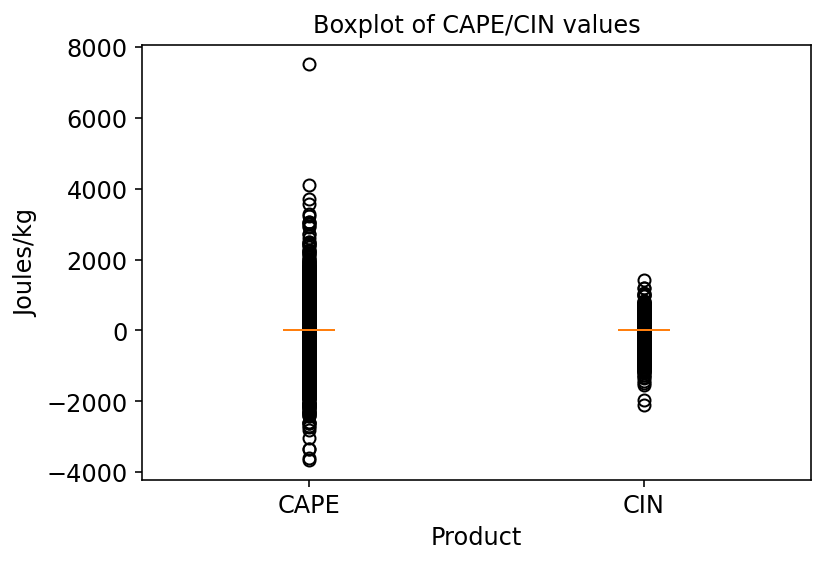

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax.boxplot(diff_cape_cin);
ax.set_xticklabels(['CAPE', 'CIN'])
ax.set_ylabel('Joules/kg'); ax.set_xlabel('Product')
ax.set_title('Boxplot of CAPE/CIN values')

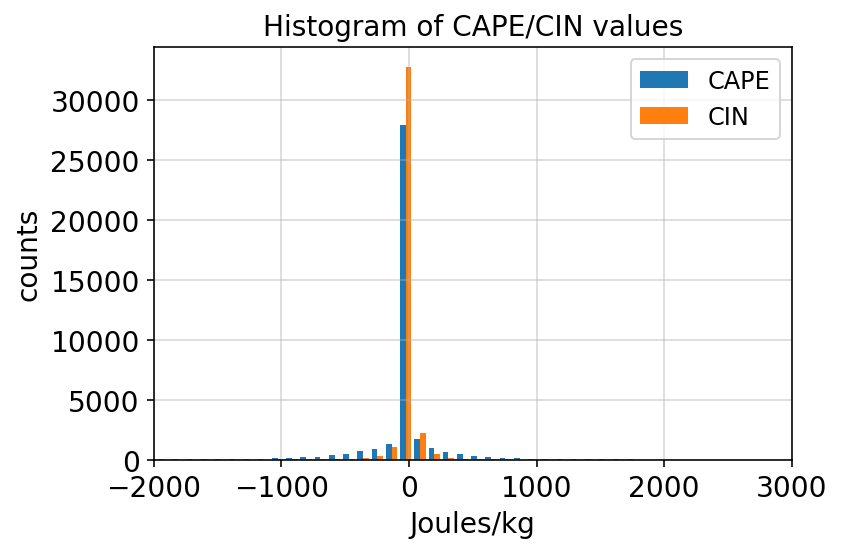

In [94]:
default_font = 14
figure_width = 6
figure_height = 4
line_width = 2.5

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax.hist(diff_cape_cin, bins=100, label=['CAPE', 'CIN']);
ax.legend(fontsize=12)
ax.set_ylabel('counts', fontsize=default_font)
ax.set_xlabel('Joules/kg', fontsize=default_font)
ax.set_title('Histogram of CAPE/CIN values', fontsize=default_font)
ax.set_xlim((-2000, 3000))
ax.grid(True, alpha=0.5)

ax.tick_params(axis='x', labelsize=default_font)
ax.tick_params(axis='y', labelsize=default_font)
        
fig.tight_layout()

In [59]:
conv_layers = [32, 64, 128, 256]
nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], conv_layers, 
                                     [(3,1)]*len(conv_layers), Ttrain.shape[1], 
                                     n_hiddens_list=[32, 16], activation='tanh', 
                                     dense_activation='tanh', dropout=False, batchnorm=False,
                                     seed=1234)
nnet.train(Xtrain, Ttrain, 100, 64, method='adam', learning_rate=0.0001, loss_f='Huber', 
           verbose=True, validation=(Xval, Tval))

epoch: 0, rmse 1.00081, val_rmse 1.00666
epoch: 20, rmse 0.94846, val_rmse 0.97523


ConvolutionalNeuralNetwork((256, 3), [32, 64, 128, 256], [(3, 1), (3, 1), (3, 1), (3, 1)], 2)
  Final objective value is 0.19368 in 137.8832 seconds.

In [60]:
nnet.model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 3)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 256, 32)           320       
_________________________________________________________________
activation (Activation)      (None, 256, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 64)           6208      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 64)           

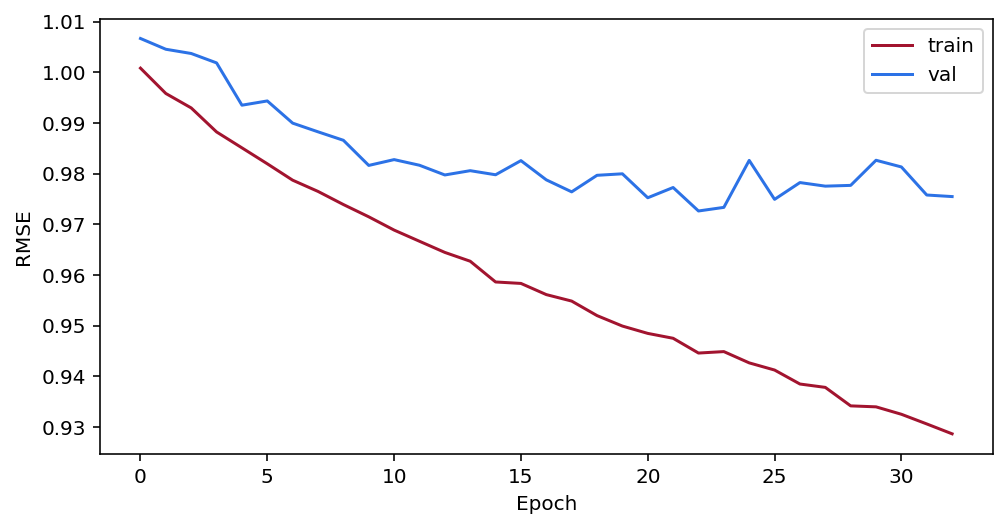

In [61]:
results.plot_loss(nnet)

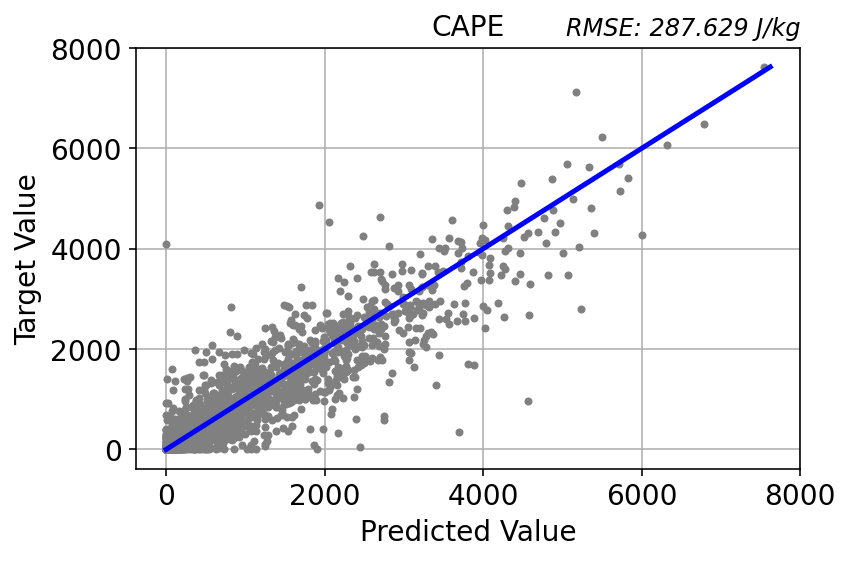

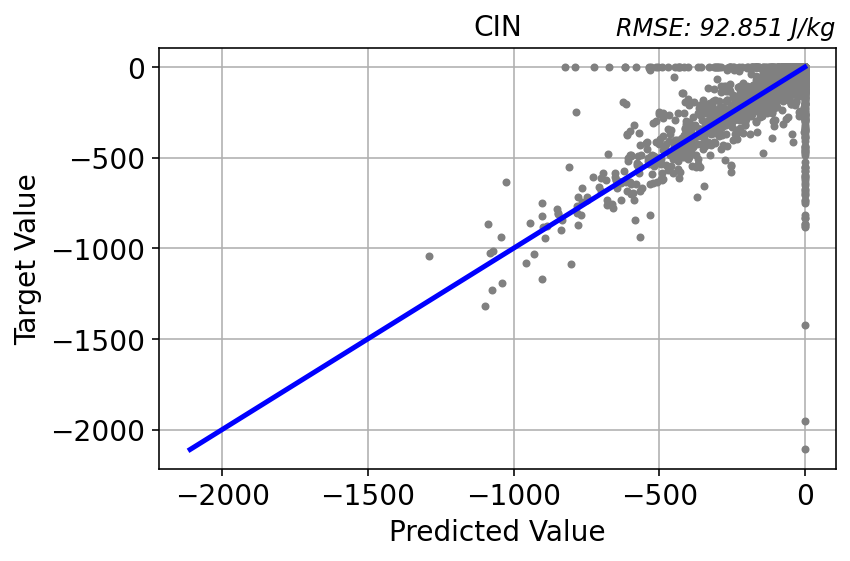

In [55]:
plot_results(RAPCCtest, RAOBCCtest)

RMSE: 194.95756399415262


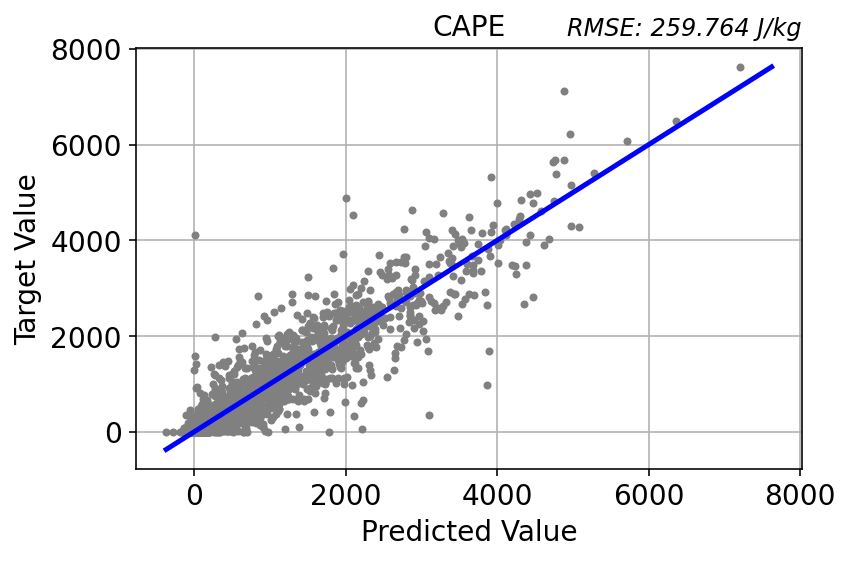

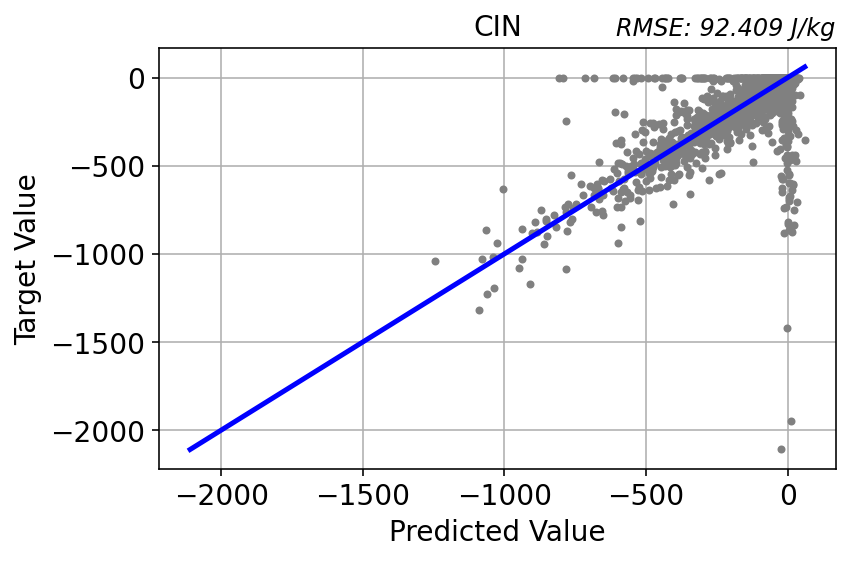

In [62]:
# Huber FC
Y = nnet.use(Xtest) 
Y = RAPCCtest + Y
print('RMSE:', ml.rmse(Y, RAOBCCtest))
plot_results(Y, RAOBCCtest) # file_name='cnn_sounding_products_diff_'


---

In [2]:
raob_cape_cin = np.load(os.path.join(VOL, 'raob_cape_cin.npy'))
rap_cape_cin = np.load(os.path.join(VOL, 'rap_cape_cin.npy'))
rap_parcel_profile = np.load(os.path.join(VOL, 'rap_parcel_profile.npy'))

nans = np.unique(np.concatenate([np.unique(np.argwhere(np.isnan(raob_cape_cin))[:, 0]),
                                 np.unique(np.argwhere(np.isnan(rap_cape_cin))[:, 0]),
                                 np.unique(np.argwhere(raob_cape_cin == 0)[:, 0]),
                                 np.unique(np.argwhere(rap_cape_cin == 0)[:, 0])]))

In [3]:
raob_cape_cin = np.delete(raob_cape_cin, nans, axis=0)
rap_cape_cin  = np.delete(rap_cape_cin, nans, axis=0)
rap_parcel_profile = np.delete(rap_parcel_profile, nans, axis=0)

raob = np.delete(raob, nans, axis=0)
rap  = np.delete(rap, nans, axis=0)
goes = np.delete(goes, nans, axis=0)
rtma = np.delete(rtma, nans, axis=0)
sonde_files = np.delete(rtma, nans, axis=0)

print(raob.shape, rap.shape, goes.shape, rtma.shape)

NameError: name 'raob' is not defined

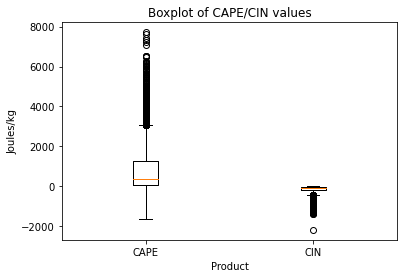

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax.boxplot(raob_cape_cin);
ax.set_xticklabels(['CAPE', 'CIN'])
ax.set_ylabel('Joules/kg'); ax.set_xlabel('Product')
ax.set_title('Boxplot of CAPE/CIN values')
plt.savefig('/home/stock/research/media/cape_cin_boxplot.pdf', dpi=300, bbox_inches='tight')

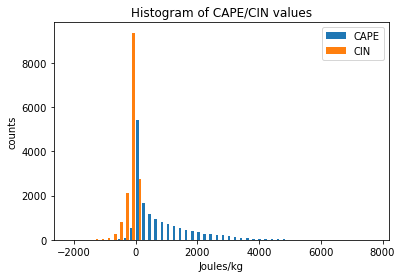

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax.hist(raob_cape_cin, bins=50, label=['CAPE', 'CIN']);
ax.legend()
ax.set_ylabel('counts'); ax.set_xlabel('Joules/kg')
ax.set_title('Histogram of CAPE/CIN values')
plt.savefig('/home/stock/research/media/cape_cin_histogram.pdf', dpi=300, bbox_inches='tight')

In [32]:
raob_cape_cin.shape, np.mean(raob_cape_cin, axis=0), np.mean(raob_cape_cin, axis=0)

((15445, 2),
 array([ 795.40190281, -131.658542  ]),
 array([ 795.40190281, -131.658542  ]))

# Fully Connected

In [82]:
r = np.concatenate([np.expand_dims(rap_parcel_profile, axis=-1), rap], axis=2)

Xtrain, Ttrain, Xtest, Ttest = ml.partition(r, raob_cape_cin, (0.8, 0.2), shuffle=True)

input_dims = [dl.PRESSURE, dl.TEMPERATURE, dl.DEWPOINT, -1]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest

Xt.shape, Tt.shape, Xe.shape, Te.shape

((64877, 1024), (64877, 2), (16219, 1024), (16219, 2))

In [83]:
nnet = nn.NeuralNetwork(Xt.shape[1], [16, 16, 16], Tt.shape[1], activation='relu',
                        batchnorm=True, dropout=True)

nnet.train(Xt, Tt, 100, 64, method='adam', learning_rate=0.0001, loss_f='MSE',
           verbose=True, validation=[Xe, Te])

epoch: 0, rmse 1.04285, val_rmse 0.78925
epoch: 20, rmse 0.70079, val_rmse 0.63737
epoch: 40, rmse 0.67700, val_rmse 0.64276
epoch: 60, rmse 0.66787, val_rmse 0.64949
epoch: 80, rmse 0.66049, val_rmse 0.63224
epoch: 99, rmse 0.66287, val_rmse 0.61639
finished!


NeuralNetwork(1024, [16, 16, 16], 2)
  Final objective value is 0.43939 in 320.6561 seconds.

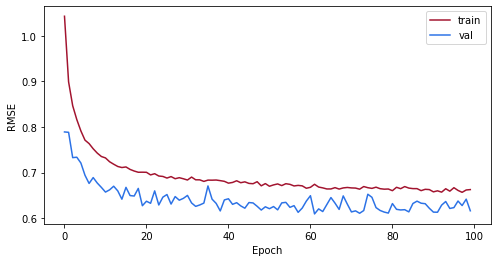

In [84]:
results.plot_loss(nnet)

RMSE: 261.08512504524083


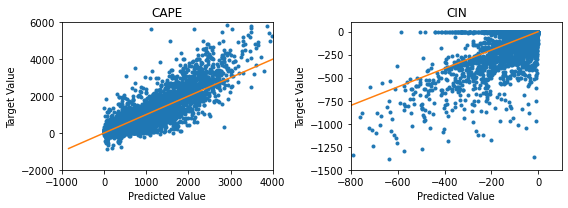

In [85]:
Y = nnet.use(Xe)
print('RMSE:', ml.rmse(Y, Te))
plot_results(Y, Te)

# Convolutional

In [206]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob_cape_cin, (0.8, 0.2), shuffle=True)

input_dims = [dl.PRESSURE, dl.TEMPERATURE, dl.DEWPOINT, dl.ALTITUDE]
Xtrain = Xtrain[:,:,input_dims]
Xtest = Xtest[:,:,input_dims]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((64877, 256, 4), (64877, 2), (16219, 256, 4), (16219, 2))

In [166]:
nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], [128, 256, 512], 
                                     [(5,1),(5,1),(5,1)], 
                                     Ttrain.shape[1], activation='relu', dropout=True)
nnet.train(Xtrain, Ttrain, 100, 64, method='adam', learning_rate=0.0001,
           verbose=True, validation=(Xtest, Ttest))

epoch: 0, rmse 1.03726, val_rmse 0.83719
epoch: 20, rmse 0.62444, val_rmse 0.65194
epoch: 40, rmse 0.59754, val_rmse 0.63557
epoch: 60, rmse 0.58404, val_rmse 0.66379
epoch: 80, rmse 0.56964, val_rmse 0.63951
epoch: 99, rmse 0.55863, val_rmse 0.65256
finished!


ConvolutionalNeuralNetwork((256, 4), [128, 256, 512], [(5, 1), (5, 1), (5, 1)], 2)
  Final objective value is 0.31207 in 786.8558 seconds.

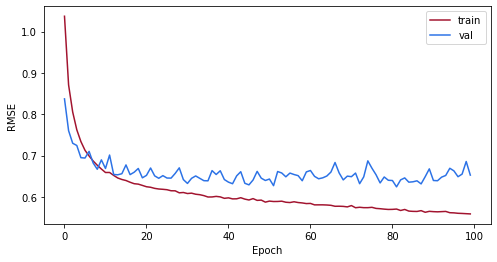

In [167]:
results.plot_loss(nnet)

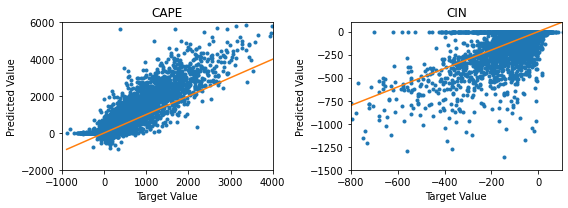

In [168]:
Y = nnet.use(Xtest)
print('RMSE:', ml.rmse(Y, Ttest))
plot_results(Y, Ttest)

# Benford's Curve

In [15]:
dydx = abs(np.diff(raob[:,:,dl.TEMPERATURE])/np.diff(raob[:,:,dl.ALTITUDE])).flatten()
raob_benfords = [int(('%e' % n).partition('.')[0]) for n in dydx]

dydx = abs(np.diff(rap[:,:,dl.TEMPERATURE])/np.diff(rap[:,:,dl.ALTITUDE])).flatten()
rap_benfords = [int(('%e' % n).partition('.')[0]) for n in dydx]

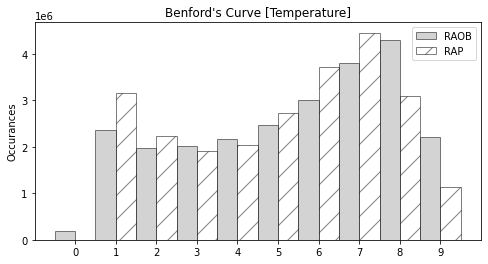

In [16]:
fig, ax = plt.subplots(figsize=(8,4))

width = 0.5

labels, counts = np.unique(raob_benfords, return_counts=True)
ax.bar(labels, counts, align='center', width=width,
       color='darkgrey', edgecolor='k', alpha=0.5, label='RAOB')

labels, counts = np.unique(rap_benfords, return_counts=True)
ax.bar(labels+width, counts, align='center', width=width,
       color='white', edgecolor='k', alpha=0.5, label='RAP', hatch='/')
plt.xticks(labels + width / 2, labels.astype(str).tolist());
ax.legend()

plt.ylabel('Occurances')
plt.title("Benford's Curve [Temperature]")

plt.savefig('/home/stock/research/media/benford_temperature', dpi=300)

In [17]:
dydx = abs(np.diff(raob[:,:,dl.DEWPOINT])/np.diff(raob[:,:,dl.ALTITUDE])).flatten()
raob_benfords = [int(('%e' % n).partition('.')[0]) for n in dydx]

dydx = abs(np.diff(rap[:,:,dl.DEWPOINT])/np.diff(rap[:,:,dl.ALTITUDE])).flatten()
rap_benfords = [int(('%e' % n).partition('.')[0]) for n in dydx]

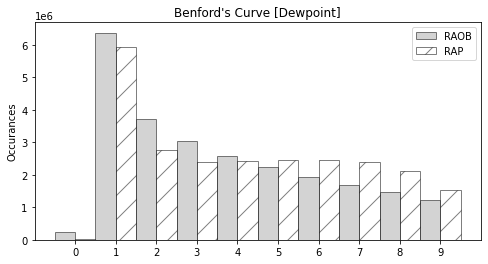

In [18]:
fig, ax = plt.subplots(figsize=(8,4))

width = 0.5

labels, counts = np.unique(raob_benfords, return_counts=True)
ax.bar(labels, counts, align='center', width=width,
       color='darkgrey', edgecolor='k', alpha=0.5, label='RAOB')

labels, counts = np.unique(rap_benfords, return_counts=True)
ax.bar(labels+width, counts, align='center', width=width,
       color='white', edgecolor='k', alpha=0.5, label='RAP', hatch='/')
plt.xticks(labels + width / 2, labels.astype(str).tolist());
ax.legend()

plt.ylabel('Occurances')
plt.title("Benford's Curve [Dewpoint]")

plt.savefig('/home/stock/research/media/benford_dewpoint', dpi=300)